In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import uncertainties as uc
from uncertainties import ufloat as uf
from uncertainties import umath as um
from uncertainties import unumpy as unp
%matplotlib inline

In [2]:
def timescanplot(fname, location, save, show, depletion=False):
    os.chdir(location)
    with open(fname, 'r') as f: file = f.readlines()
    
    skip = [num for num, line in enumerate(file) if 'ALL:' in line.split()]
    iterations = np.array([int(i.split()[-1].strip()) for i in file if '#mass' in i.split()])
    length = len(iterations)

    data = np.genfromtxt(fname, skip_header = skip[0]+1)

    cycle = int(len(data)/iterations.sum())
    time = data[:,1][:cycle]

    temp, temp1, temp2, mass, counts = [], [], [], [], []
    k = 0
    for i in range(len(iterations)):
        j = iterations[i]*cycle
        mass.append(data[:,0][k])
        counts.append(data[:,2][k:k+j])
        k += j
        
        for c in range(cycle):
            for l in range(iterations[i]):
                temp.append(counts[i][(l*cycle)+c])
            temp1.append(temp)
            temp = []
        temp2.append(temp1)
        temp1 = []
        
    mean = [[np.array(temp2[i][j]).mean() for j in range(cycle)]for i in range(length)]
    error = [[(np.array(temp2[i][j]).std()) for j in range(cycle)]for i in range(length)]
    mass, mean, error = np.array(mass), np.array(mean), np.array(error)

    if depletion: return mass, iterations, mean, error, time

    plt.figure(figsize=(15,5), dpi=100)

    for i in range(length):
        lg = "%i:%i"%(mass[i], iterations[i])
        plt.errorbar(time, mean[i],error[i],fmt='.-', label = lg)
        
    plt.title('Time Scan plot for %s'%fname)
    plt.xlabel('Time (ms)')
    plt.ylabel('Counts')
    plt.legend()
    plt.tight_layout()

    if save: plt.savefig(fname.split('.')[0]+'.png')
    if show: plt.show()
    
    plt.close()

['K,,ON,,']


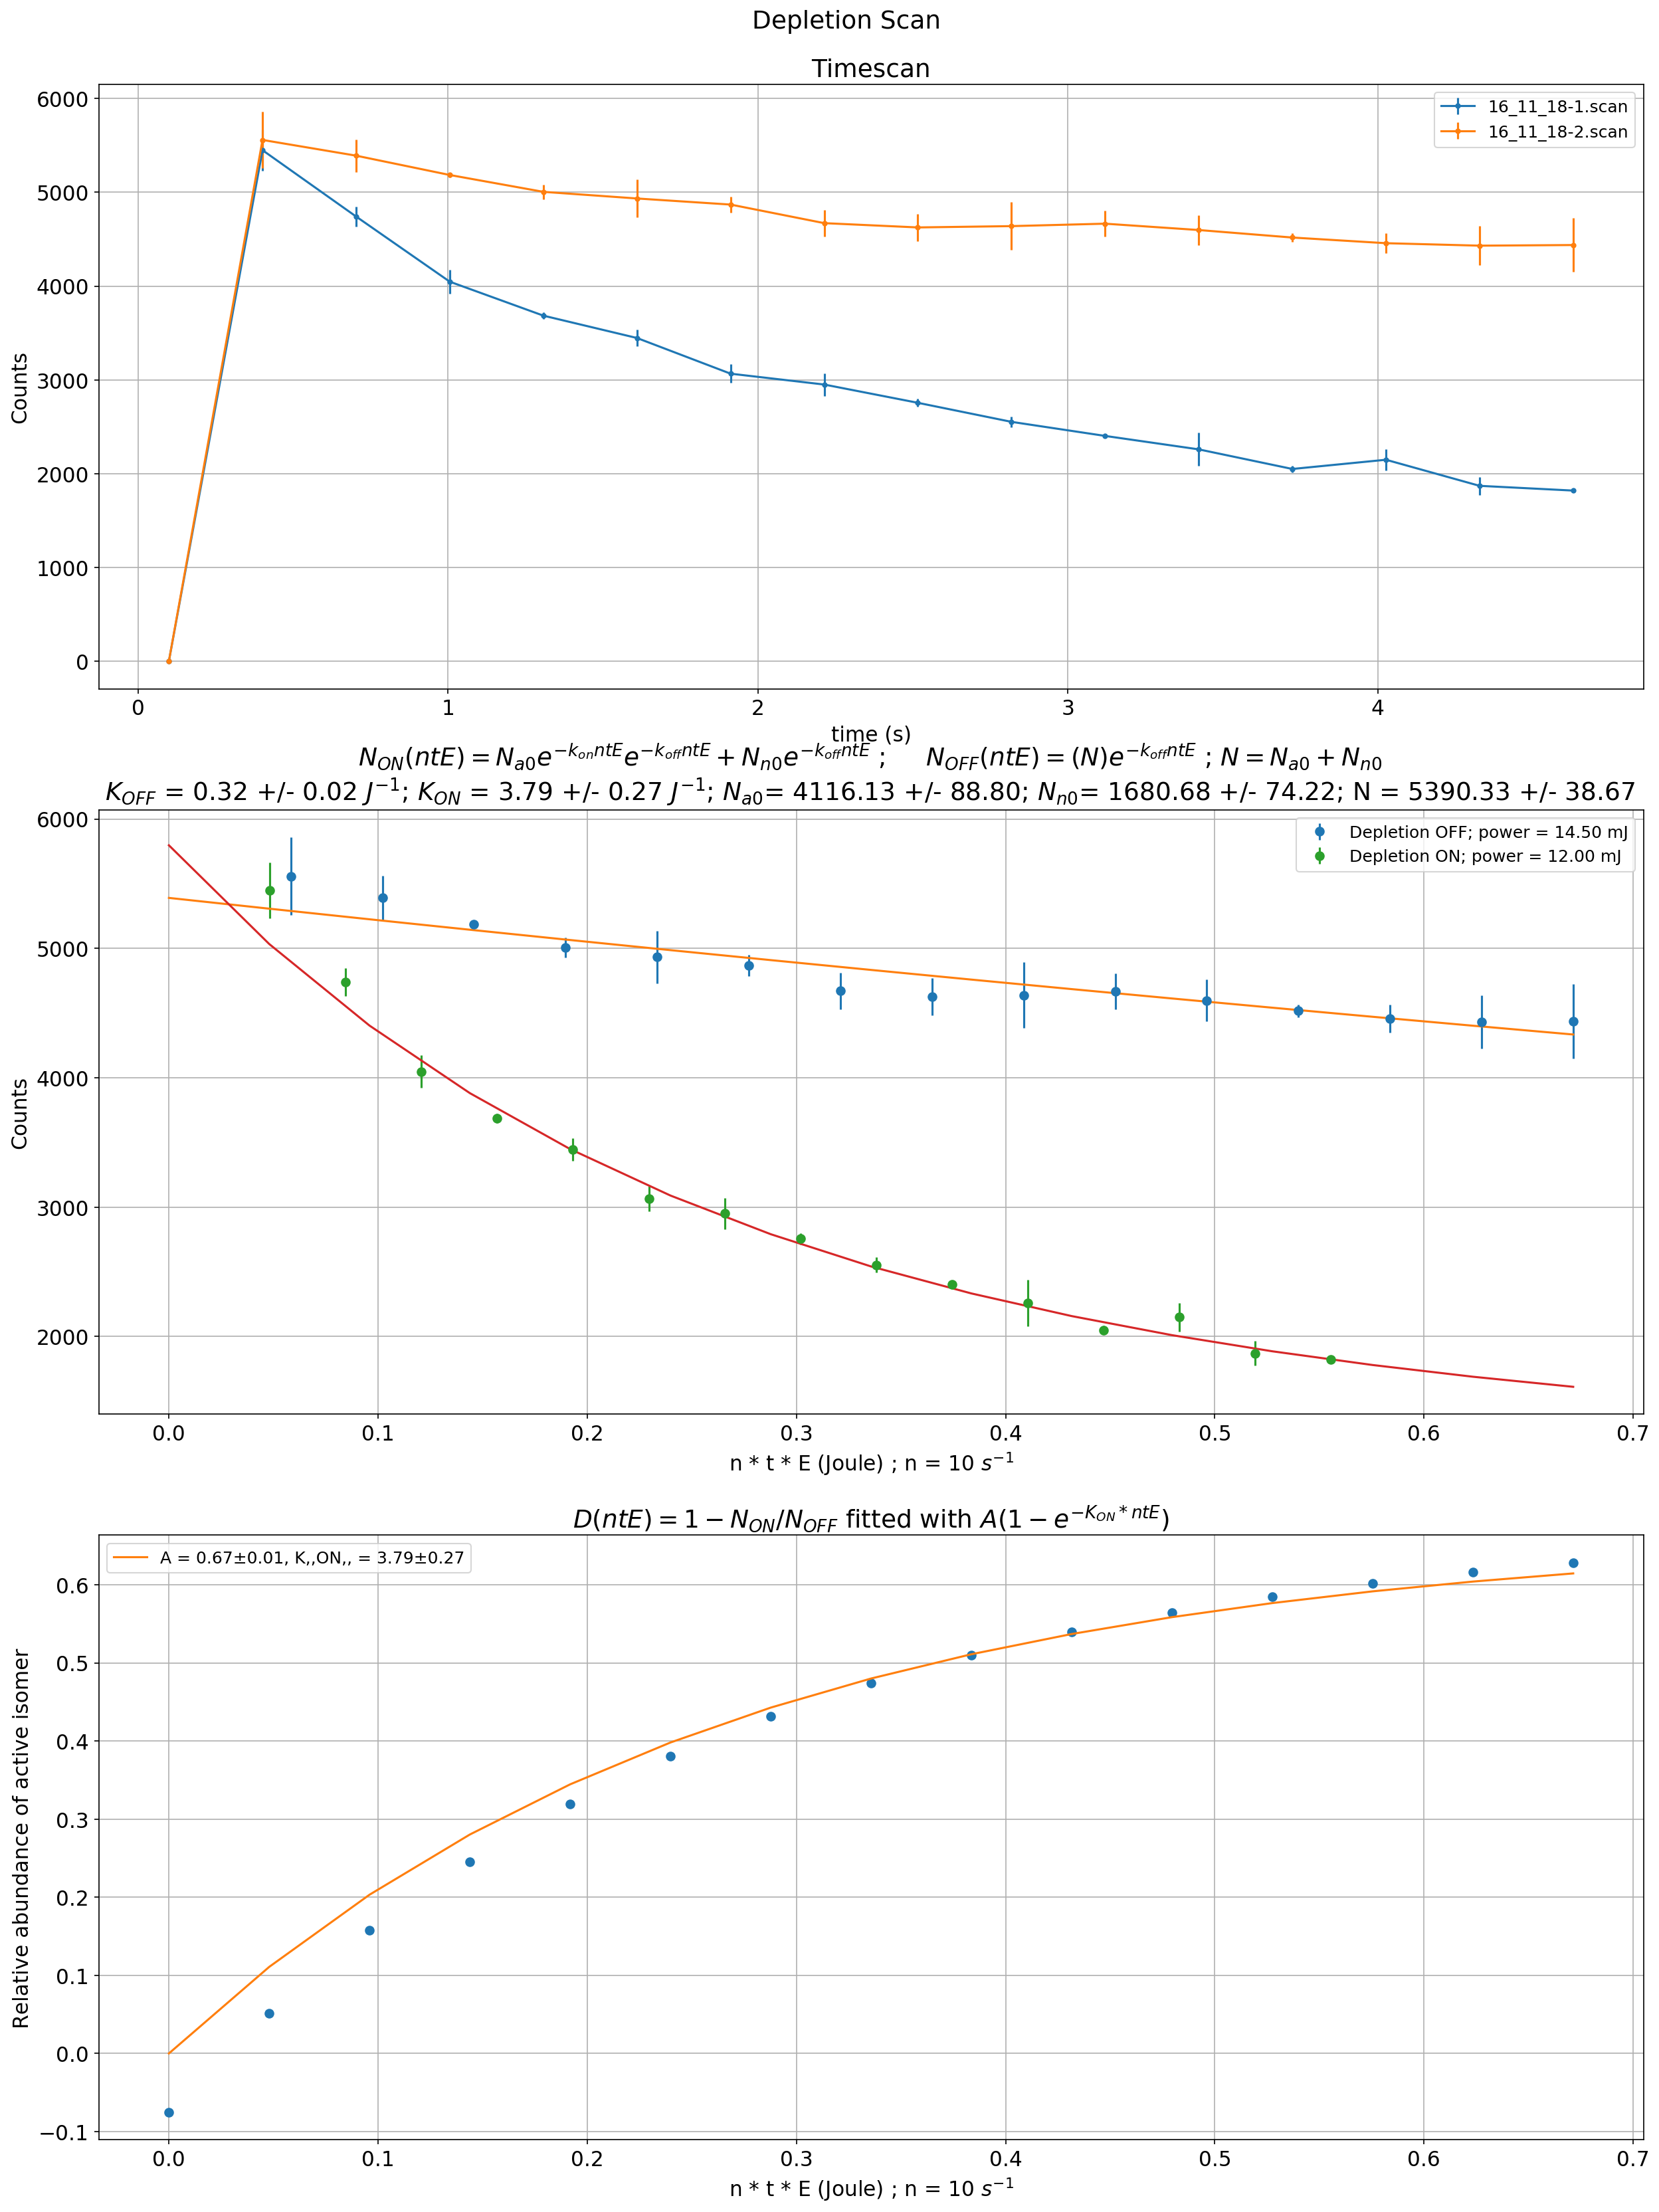

In [45]:
def depletionPlot2(files, location, save, show, power_values, n):
    
    power_values = np.array(power_values)
    
    np.seterr(all='ignore')
    
    os.chdir(location)
    
    plt.rcParams['figure.figsize'] = (20,25)
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams.update({'font.size': 15})
    
    fig, axs = plt.subplots(3, sharex=False) 
    graph = {'timescan': axs[0], 'depletion1': axs[1], 'depletion2': axs[2]}

    plt.subplots_adjust(top=0.95, hspace = 0.2)
    plt.suptitle('Depletion Scan')
    
    full, stde, new_stde = [], [], []
    for f in files:        
        mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
        time = time/1000
        x, y = time, mean[0]
        
        full.append(y)
        stde.append(error[0])
        new_stde.append(error[0][1:])
        
        graph['timescan'].errorbar(x, y,yerr=error[0], fmt='.-', label=f)
        
    time = np.array(time)
    
    for i in range(0, len(full), 2):
        
        depletion = 1-(full[i]/full[i+1])

        new_time = time[1:]
        new_depletion = depletion[1:]
        
        depletion_ON = full[i][1:]
        depletion_OFF = full[i+1][1:]
        
        depletion_ON_err = new_stde[i]
        depletion_OFF_err = new_stde[i+1]
        
        power_ON = (power_values[i]*n*new_time)/1000.
        power_OFF = (power_values[i+1]*n*new_time)/1000.
        
        counts_max_guess_OFF = depletion_OFF[1] - depletion_OFF[0]
        counts_max_guess_ON = depletion_ON[1] - depletion_ON[0]
        
        power_max = power_values.max()*n*time.max()/1000.
        power_new = np.linspace(0, power_max, num=len(new_depletion))
        
        ############## Depletion OFF ##############
        def N_OFF(x, K_OFF, N):
            return (N)*np.exp(-K_OFF*x)
        x_OFF, d_OFF = np.array(power_OFF), np.array(depletion_OFF)
        graph['depletion1'].errorbar(x_OFF, d_OFF, yerr = new_stde[i+1],fmt = 'o', label = 'Depletion OFF; power = %.2f mJ'%power_values[i+1])
        
        # Curve fit
        new_stde[i+1][new_stde[i+1]==0]=10e-10
        
        pop_OFF, popc_OFF = curve_fit(N_OFF, x_OFF, d_OFF,
                sigma = new_stde[i+1],
                absolute_sigma=True,
                bounds = ([-np.inf, 0],[np.inf, d_OFF.max()+counts_max_guess_OFF])
                                     )
        perr_OFF = np.sqrt(np.diag(popc_OFF))
        K_OFF_err, N_err = perr_OFF
        
        K_OFF, N = pop_OFF
        y_OFF = N_OFF(power_new, K_OFF, N )
        graph['depletion1'].plot(power_new, y_OFF,
                                 #label = '$N_{OFF}(t)=(%.2f)e^{-(%.2f)*t}$'%(N, K_OFF)
                                )
          
        ############## Depletion ON ##############
        def N_ON(X, Na0, Nn0, K_ON):
            x, K_OFF = X
            return Na0*np.exp(-K_ON*x)*np.exp(-K_OFF*x) + Nn0*np.exp(-K_OFF*x)
        x_ON, d_ON = np.array(power_ON), np.array(depletion_ON)
        graph['depletion1'].errorbar(x_ON, d_ON, yerr = new_stde[i], fmt = 'o', label = 'Depletion ON; power = %.2f mJ'%power_values[i])
        
        # Curve fit
        X = (x_ON, K_OFF)
        new_stde[i][new_stde[i]==0]=10e-10
        pop_ON, popc_ON = curve_fit(N_ON, X, d_ON,
                    sigma = new_stde[i],
                    absolute_sigma=True,
                    bounds = ([0,0,-np.inf,],[N, N, np.inf])
                                   )
        
        perr_ON = np.sqrt(np.diag(popc_ON))
        Na0_err, Nn0_err, K_ON_err = perr_ON
        Na0, Nn0, K_ON = pop_ON
        
        y_ON = N_ON((power_new, K_OFF), Na0, Nn0, K_ON)
        graph['depletion1'].plot(power_new, y_ON,
                        #label = '$N_{ON}(ntE)=(%.2f)e^{-(%.2f)*ntE}e^{-(%.2f)*ntE}$ \n + $(%.2f)e^{-(%.2f)*ntE}$'%(Na0,K_ON,K_OFF,Nn0, K_OFF)
                                )
        
        ############## Depletion percentage ##############
        def Depletion(X, A):
            x, K_ON = X
            return A*(1-np.exp(-K_ON*x))

        upower_new, uK_ON, uK_OFF, uNa0, uNn0, uN = unp.uarray(power_new, np.zeros(len(power_new))), uf(K_ON, K_ON_err), uf(K_OFF, K_OFF_err), uf(Na0, Na0_err), uf(Nn0, Nn0_err), uf(N, N_err)

        uy_OFF = lambda x, uN, uK_OFF: uN*unp.exp(-uK_OFF*x)
        uy_ON = lambda x, uNa0, uNn0, uK_OFF, uK_ON : uNa0*unp.exp(-uK_ON*x)*unp.exp(-uK_OFF*x) + uNn0*unp.exp(-uK_OFF*x)

        udepletion = 1 - uy_ON(upower_new, uNa0, uNn0, uK_OFF, uK_ON)/uy_OFF(upower_new, uN, uK_OFF)
        depletion, depletion_error = unp.nominal_values(udepletion), unp.std_devs(udepletion)
        
        graph['depletion2'].plot(power_new, depletion, 'o')

        
        X = (power_new, K_ON)
        
        pop_depletion, poc_depletion = curve_fit(Depletion, X, depletion, sigma = depletion_error, absolute_sigma = True)
        
        A = pop_depletion
        A_err = np.sqrt(np.diag(poc_depletion))
        uA = uf(A, A_err)
        
        name_strings = ["K,,ON,,"]
        print(name_strings)
        y_depletion = Depletion(X, A)
        graph['depletion2'].plot(power_new, y_depletion, 
                                 label = 'A = {:.2P}, K,,ON,, = {:.3P}'.format(uA, uK_ON)
                                )
        
    graph['depletion1'].set_title('$N_{ON}(ntE)=N_{a0}e^{-k_{on}ntE}e^{-k_{off}ntE} + N_{n0}e^{-k_{off}ntE}$ ;\t$N_{OFF}(ntE)=(N)e^{-k_{off}ntE}$ ; $N = N_{a0}+ N_{n0}$ \n' 
            '$K_{OFF}$ = %.2f +/- %.2f $J^{-1}$; $K_{ON}$ = %.2f +/- %.2f $J^{-1}$; $N_{a0}$= %.2f +/- %.2f; $N_{n0}$= %.2f +/- %.2f; N = %.2f +/- %.2f '%(K_OFF, K_OFF_err, K_ON, K_ON_err, Na0, Na0_err, Nn0, Nn0_err, N, N_err))
    graph['depletion1'].set_xlabel('n * t * E (Joule) ; n = %i $s^{-1}$'%n)
    graph['depletion1'].set_ylabel('Counts')
    
    graph['timescan'].set_title('Timescan')
    graph['timescan'].set_xlabel('time (s)')
    graph['timescan'].set_ylabel('Counts')
    
    graph['depletion2'].set_title('$D(ntE)=1-N_{ON}/N_{OFF}$ fitted with $A(1-e^{-K_{ON} * ntE})$')
    graph['depletion2'].set_xlabel('n * t * E (Joule) ; n = %i $s^{-1}$'%n)
    graph['depletion2'].set_ylabel('Relative abundance of active isomer')

    for axs in axs.flat:
        axs.grid(True)
        #box = axs.get_position()
        #axs.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        #axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs.legend(fontsize=12)
    
    if save: plt.savefig("Depletion.pdf", bbox_inches='tight')
    if show: plt.show()
    plt.tight_layout()
    plt.close()

files1 = ['16_11_18-1.scan', '16_11_18-2.scan']
files2 = ['16_11_18-4.scan', '16_11_18-3.scan']
files3 = ['16_11_18-1.scan', '16_11_18-2.scan', '16_11_18-4.scan', '16_11_18-3.scan']
location = r'D:\FELion-Spectrum-Analyser\testing\_datas'

power1, power2, power3 = [12, 14.5], [22, 25], [12, 14.5, 22, 25]
depletionPlot2(files1, location, save=False, show=True, power_values=power1,n=10)

In [35]:

f = '16_11_18-3.scan'
save, show = False, False
mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
mean, error, time = mean[0][1:], error[0][1:], time[1:]
mean = unp.uarray(mean, error)

#print(unp.nominal_values(mean), unp.std_devs(mean), mean)
#print("Mean values 1: {:.2f}, {:.2e}, {:.2uP}".format(mean[0], mean[0], mean[0]))
time = unp.uarray(time, np.zeros(len(time)))
temp = mean*np.exp(np.zeros(len(mean))+2)
print("Mean values 1: {:.2f} ".format(mean[0]))

Mean values 1: 1559.50+/-231.50 
